In [2]:
import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict

sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/T-RECS-RS-research')
from prelim_experiments.param_experiments.chaney_utils import (
    load_sim_results,
    graph_relative_to_ideal,
    merge_results,
    graph_metrics,
    graph_metrics_by_axis,
    graph_relative_to_global_by_axis,
    transform_relative_to_global,
    graph_histogram_metric_by_axis,
    graph_averaged_metric_by_axis
)
from wrapper.models.bubble import BubbleBurster
from src.utils import compute_constrained_clusters, create_global_user_pairs, user_topic_mapping, create_cluster_user_pairs, load_and_process_movielens, compute_embeddings
from wrapper.metrics.clustering_metrics import MeanCosineSim, MeanDistanceFromCentroid, MeanCosineSimPerCluster, MeanDistanceFromCentroidPerCluster
from prelim_experiments.param_experiments.chaney_utils import *

import warnings
warnings.simplefilter("ignore")

import itertools
import os

In [2]:
single_training_path = "sim_results/single_training"
single_training_dirs = []
for root, dirs, files in os.walk(single_training_path):
    for dirname in sorted(dirs):
        if dirname == "random_interleaving-0retraining-0probabilistic-5random_items_per_iter":
            continue
        single_training_dirs.append(root + "/" + dirname)
        
repeated_training_path = "sim_results/repeated_training"
repeated_training_dirs = []
for root, dirs, files in os.walk(repeated_training_path):
    for dirname in sorted(dirs):
        if dirname == "random_interleaving-1retraining-0probabilistic-5random_items_per_iter":
            continue
        repeated_training_dirs.append(root + "/" + dirname)

# for i in range(len(single_training_dirs)):
#     print(single_training_dirs[i])
#     print(repeated_training_dirs[i])

In [3]:
# results_path = ["sim_results/repeated_training/tester"]
# results_file = ["sim_results.pkl"]
# environment_file = ["sim_environment.pkl"]
# diagnostics_file = ["sim_diagnostics.pkl"]

# print()
# results = merge_results(results_path, results_file)
# print(results.keys())
# print(results["mse"].keys())
# print(results["mean_global_cosine_sim"]["tester_Trueretraining_Trueprobabilistic"])

# print()
# diagnostics = load_sim_results(results_path[0], diagnostics_file[0])
# print(diagnostics.keys())
# print(diagnostics["mean_global_cosine_sim"].keys())
# print(diagnostics["mean_global_cosine_sim"]["tester_Trueretraining_Trueprobabilistic"].keys())
# print(diagnostics["mean_global_cosine_sim"]["tester_Trueretraining_Trueprobabilistic"]["max"])

# print()
# environment = merge_results(results_path, environment_file)
# print(environment.keys())
# print(environment["user_cluster_centroids"].keys())
# print(environment["user_cluster_centroids"]["tester_Trueretraining_Trueprobabilistic"][0].shape)


In [4]:
results_files = ["sim_results.pkl"] * len(single_training_dirs)

print("SINGLE training results")
single_training_results = merge_results(single_training_dirs, results_files)
print(len(single_training_results.keys()))
print(single_training_results.keys())
print(len(single_training_results["mse"].keys()))
print(single_training_results["mse"].keys())
print(len(single_training_results["mean_global_cosine_sim"]["xquad_binary_0.25alpha"]))
print(len(single_training_results["mean_global_cosine_sim"]["xquad_binary_0.25alpha"][0]))

print("\nREPEATED training results")
repeated_training_results = merge_results(repeated_training_dirs, results_files)
print(len(repeated_training_results.keys()))
print(repeated_training_results.keys())
print(len(repeated_training_results["mse"].keys()))
print(repeated_training_results["mse"].keys())
print(len(repeated_training_results["mean_global_cosine_sim"]["xquad_binary_0.25alpha"]))
print(len(repeated_training_results["mean_global_cosine_sim"]["xquad_binary_0.25alpha"][0]))

SINGLE training results
19
dict_keys(['mse', 'interaction_spread', 'global_interaction_similarity', 'inter_cluster_interaction_similarity', 'intra_cluster_interaction_similarity', 'mean_global_cosine_sim', 'mean_intra_cluster_cosine_sim', 'mean_inter_cluster_cosine_sim', 'mean_cosine_sim_per_cluster', 'mean_cluster_distance_from_centroid', 'mean_global_distance_from_centroid', 'mean_distance_from_centroid_per_cluster', 'interaction_histogram', 'rmse', 'mean_novelty', 'mean_slate_topic_diversity', 'topic_interaction_histogram', 'topic_interaction_spread', 'mse_per_user'])
8
dict_keys(['baseline_myopic-0retraining-0probabilistic', 'baseline_myopic-0retraining-0probabilistic-1repeated_items_repeat_interactions-1repeated_items_repeat_interactions', 'probabilistic_recommender-0retraining-1probabilistic-Falserepeated_items_repeat_interactions', 'random_recommender-0retraining-Falseprobabilistic-10random_items_per_iter', 'xquad_binary_0.1alpha', 'xquad_binary_0.25alpha', 'xquad_smooth_0.1alph

In [5]:
y_labels = dict([
    ("mse", "mse"), 
    ("interaction_spread", "item interaction spread"), 
    ("global_interaction_similarity", "average jacard similarity"), 
    ("inter_cluster_interaction_similarity", "average jacard similarity"), 
    ("intra_cluster_interaction_similarity", "average jacard similarity"), 
    ("mean_global_cosine_sim", "average cosine sim"),
    ("mean_intra_cluster_cosine_sim", "average cosine sim"),
    ("mean_inter_cluster_cosine_sim", "average cosine sim"),
    ("mean_cosine_sim_per_cluster", "average cosine sim"),
    ("mean_cluster_distance_from_centroid", "distance"),
    ("mean_global_distance_from_centroid", "distance"),
    ("mean_distance_from_centroid_per_cluster", "distance"),
    ("interaction_histogram", "No. interactions per item"),
    ("rmse", "rmse"),
    ("mean_novelty", "average novelty"),
    ("mean_slate_topic_diversity", "average topic diversity across rec slates"),
    ("topic_interaction_histogram", "No. interactions per topic"),
    ("topic_interaction_spread", "topic interaction spread"),
    ("mse_per_user", "mse per user")
])

In [6]:
# # for key in single_training_results["mean_novelty"].keys():
# #     print(single_training_results["mean_novelty"][key][0])
# """
# mean_novelty to fix:
#     Single training:
#         - "baseline_myopic-0retraining-0probabilistic"
#         - "probabilistic_recommender-0retraining-1probabilistic-Falserepeated_items_repeat_interactions"
#         - "random_recommender-0retraining-Falseprobabilistic-10random_items_per_iter"
#     Repeated training:
#         - "baseline_myopic-1retraining-0probabilistic-0repeated_items_repeat_interactions"
#         - "baseline_myopic-1retraining-0probabilistic-1repeated_items_repeat_interactions"
#         - "probabilistic_recommender-1retraining-1probabilistic"
#         - "random_recommender-1retraining-Falseprobabilistic-10random_items_per_iter"
# """    
# novelty_to_fix_single_training = [
#     "baseline_myopic-0retraining-0probabilistic", 
#     "probabilistic_recommender-0retraining-1probabilistic-Falserepeated_items_repeat_interactions", 
#     "random_recommender-0retraining-Falseprobabilistic-10random_items_per_iter"
# ]
# novelty_to_fix_repeated_training = [
#     "baseline_myopic-1retraining-0probabilistic-0repeated_items_repeat_interactions",
#     "baseline_myopic-1retraining-0probabilistic-1repeated_items_repeat_interactions",
#     "probabilistic_recommender-1retraining-1probabilistic",
#     "random_recommender-1retraining-Falseprobabilistic-10random_items_per_iter"
# ]

# for model_name in novelty_to_fix_single_training:
#     for trial_num in range(len(single_training_results["mean_novelty"][model_name])):
#         single_training_results["mean_novelty"][model_name][trial_num] = single_training_results["mean_novelty"][model_name][trial_num][:50] + [np.nanmean(x) for x in single_training_results["mean_novelty"][model_name][trial_num][50:]]
        
# for model_name in novelty_to_fix_repeated_training:
#     for trial_num in range(len(repeated_training_results["mean_novelty"][model_name])):
#         repeated_training_results["mean_novelty"][model_name][trial_num] = repeated_training_results["mean_novelty"][model_name][trial_num][:50] + [np.nanmean(x) for x in repeated_training_results["mean_novelty"][model_name][trial_num][10:]]

In [7]:
# def merge_diagnostics_results(folder_paths, file_names):
#     assert (len(folder_paths) == len(file_names)), "Must supply same number of folder paths and file names"
    
#     final_diagnostics = defaultdict(lambda: defaultdict(list))

#     for idx in range(len(folder_paths)):
#         model_diagnostics = defaultdict(lambda: defaultdict(list))
#         results = load_sim_results(folder_paths[idx], file_names[idx])
#         for metric_name, v in results.items():
#             for model_name, diagnostic in v.items():
#                 for diag, diag_vals in diagnostic.items():
#                     # print(metric_name, model_name, diag)
#                     model_diagnostics[metric_name][diag] = [vals.tolist() for vals in diag_vals]
                    
#                 for metric in model_diagnostics:
#                     final_diagnostics[metric][model_name] = model_diagnostics[metric]
            
#     return final_diagnostics

In [8]:
# diagnostics_files = ["sim_diagnostics.pkl"] * len(single_training_dirs)
# diagnostics_merged = merge_diagnostics_results(single_training_dirs, diagnostics_files)
# print(diagnostics_merged["mean_novelty"].keys())

# for model_name, res in single_training_results["mean_novelty"].items():
#     check_equal = list()
#     for sim_num in range(len(res)):
#         check_equal.append(res[sim_num][50:] == diagnostics_merged["mean_novelty"][model_name]["mean"][sim_num])
#     print(model_name, "\n\t", check_equal)#, res)

In [9]:
# diagnostics_files = ["sim_diagnostics.pkl"] * len(repeated_training_dirs)
# diagnostics_merged = merge_diagnostics_results(repeated_training_dirs, diagnostics_files)
# print(diagnostics_merged["mean_novelty"].keys())

# for model_name, res in repeated_training_results["mean_novelty"].items():
#     check_equal = list()
#     for sim_num in range(len(res)):
#         check_equal.append(res[sim_num][50:] == diagnostics_merged["mean_novelty"][model_name]["mean"][sim_num])
#     print(model_name, "\n\t", check_equal)#, res)

In [10]:
model_keys_by_training = {
    "repeated_training":list(repeated_training_results["mse"].keys()),
    "single_training":list(single_training_results["mse"].keys())
}

id_to_readable_single_training = {
    'baseline_myopic-0retraining-0probabilistic':'baseline_myopic',
    'baseline_myopic-0retraining-0probabilistic-1repeated_items_repeat_interactions-1repeated_items_repeat_interactions':'baseline_myopic-1repeated_items_repeat_interactions',
    'probabilistic_recommender-0retraining-1probabilistic-Falserepeated_items_repeat_interactions':'probabilistic_recommender',
    'random_recommender-0retraining-Falseprobabilistic-10random_items_per_iter':'random_recommender',
    'xquad_binary_0.1alpha':'xquad_binary_0.1alpha',
    'xquad_binary_0.25alpha':'xquad_binary_0.25alpha',
    'xquad_smooth_0.1alpha':'xquad_smooth_0.1alpha',
    'xquad_smooth_0.25alpha':'xquad_smooth_0.25alpha'
}

id_to_readable_repeated_training = {
    'baseline_myopic-1retraining-0probabilistic-0repeated_items_repeat_interactions':'baseline_myopic',
    'baseline_myopic-1retraining-0probabilistic-1repeated_items_repeat_interactions':'baseline_myopic-1repeated_items_repeat_interactions',
    'probabilistic_recommender-1retraining-1probabilistic':'probabilistic_recommender',
    'random_recommender-1retraining-Falseprobabilistic-10random_items_per_iter':'random_recommender',
    'xquad_binary_0.1alpha':'xquad_binary_0.1alpha',
    'xquad_binary_0.25alpha':'xquad_binary_0.25alpha',
    'xquad_smooth_0.1alpha':'xquad_smooth_0.1alpha',
    'xquad_smooth_0.25alpha':'xquad_smooth_0.25alpha'
}

# Graphing `mse`

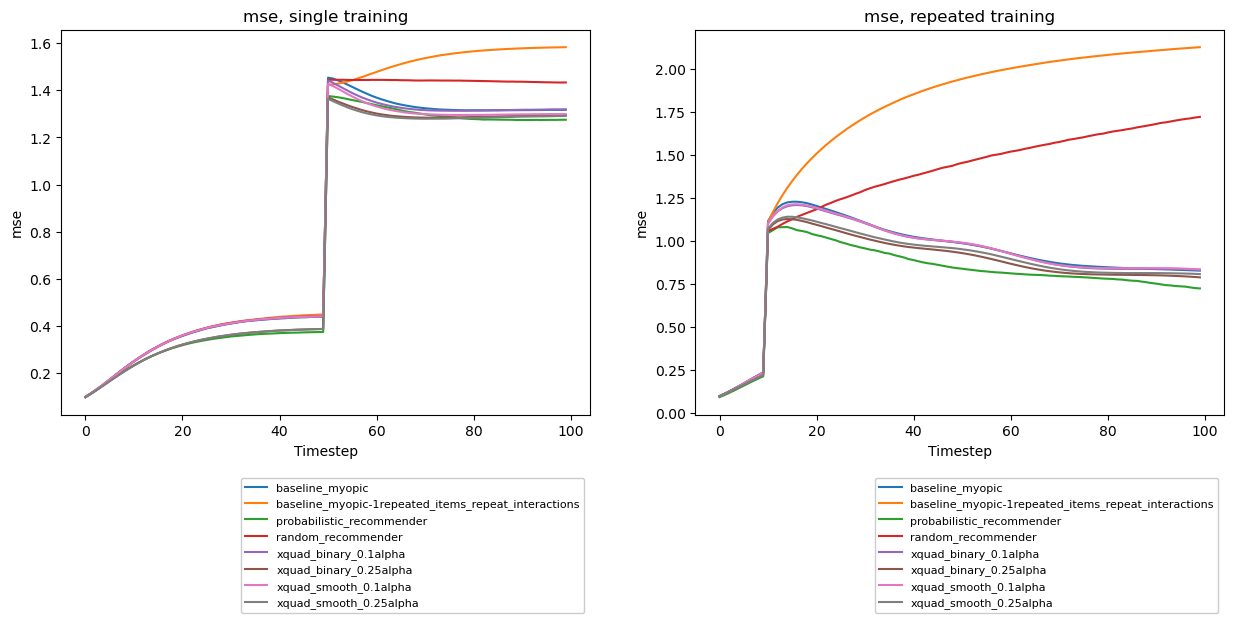

In [11]:
metric_key = "mse"

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

graph_metrics_by_axis(axs[0], single_training_results, metric_key, model_keys_by_training["single_training"], id_to_readable_single_training, mult_sd=0)
axs[0].set_ylabel(y_labels[metric_key])
axs[0].set_xlabel("Timestep")
axs[0].set_title(f"{metric_key}, single training")
axs[0].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, -0.15), fontsize="8",)

graph_metrics_by_axis(axs[1], repeated_training_results, metric_key, model_keys_by_training["repeated_training"], id_to_readable_repeated_training, mult_sd=0)
axs[1].set_ylabel(y_labels[metric_key])
axs[1].set_xlabel("Timestep")
axs[1].set_title(f"{metric_key}, repeated training")
axs[1].legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1, -0.15), fontsize="8",)

In [47]:
diagnostic_metrics = set((
    "mse",
    "global_interaction_similarity",
    "inter_cluster_interaction_similarity",
    "intra_cluster_interaction_similarity",
    "mean_global_cosine_sim",
    "mean_intra_cluster_cosine_sim",
    "mean_inter_cluster_cosine_sim",
    "mean_cosine_sim_per_cluster",
    "mean_cluster_distance_from_centroid",
    "mean_global_distance_from_centroid",
    "mean_novelty"
))
diagnostics_vars = ["mean", "std", "median", "min", "max", "skew"]
metric_diagnostics = {k: defaultdict(list) for k in diagnostics_vars}
result_diagnostics = {k: defaultdict(list) for k in diagnostic_metrics}

print(metric_diagnostics)
print()
print(result_diagnostics)

{'mean': defaultdict(<class 'list'>, {}), 'std': defaultdict(<class 'list'>, {}), 'median': defaultdict(<class 'list'>, {}), 'min': defaultdict(<class 'list'>, {}), 'max': defaultdict(<class 'list'>, {}), 'skew': defaultdict(<class 'list'>, {})}

{'mean_global_distance_from_centroid': defaultdict(<class 'list'>, {}), 'intra_cluster_interaction_similarity': defaultdict(<class 'list'>, {}), 'mse': defaultdict(<class 'list'>, {}), 'mean_global_cosine_sim': defaultdict(<class 'list'>, {}), 'global_interaction_similarity': defaultdict(<class 'list'>, {}), 'mean_cosine_sim_per_cluster': defaultdict(<class 'list'>, {}), 'mean_inter_cluster_cosine_sim': defaultdict(<class 'list'>, {}), 'mean_cluster_distance_from_centroid': defaultdict(<class 'list'>, {}), 'inter_cluster_interaction_similarity': defaultdict(<class 'list'>, {}), 'mean_novelty': defaultdict(<class 'list'>, {}), 'mean_intra_cluster_cosine_sim': defaultdict(<class 'list'>, {})}


In [48]:
model_name = "model1"
for metric in diagnostic_metrics:
    metric_diag = result_diagnostics[metric][model_name]
    for diagnostic in diagnostics_vars:
        # result_diagnostics[metric][model_name][diagnostic].append(np.arange(10))
        metric_diag.append(np.arange(10))
    result_diagnostics[metric][model_name] = metric_diag
result_diagnostics

{'mean_global_distance_from_centroid': defaultdict(list,
             {'model1': [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]}),
 'intra_cluster_interaction_similarity': defaultdict(list,
             {'model1': [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]}),
 'mse': defaultdict(list,
             {'model1': [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
            

In [26]:
model_name = "model69"
for metric in diagnostic_metrics:
    metric_diag = result_diagnostics[metric][model_name]
    for diagnostic in diagnostics_vars:
        # result_diagnostics[metric][model_name][diagnostic].append(np.arange(10))
        metric_diag.append(np.arange(10))
    result_diagnostics[metric][model_name] = metric_diag
result_diagnostics

{'intra_cluster_interaction_similarity': defaultdict(list,
             {'model1': [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])],
              'model69': [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]}),
 'global_interaction_similarity': defaultdict(list,
             {'model1': [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
               array([0, 1, 2, 3, 4, 5, 6, 7

In [117]:
# single_training_path = "all_sim_results/initial_test/single_training"
single_training_dirs = ["all_sim_results/initial_test/single_training"]

results_file = ["sim_results.pkl"]
environment_file = ["sim_environment.pkl"]
diagnostics_file = ["sim_diagnostics.pkl"]

# print("SINGLE training results")
# single_training_results = merge_results(single_training_dirs, results_files)
# print(len(single_training_results.keys()), single_training_results.keys())
# metrics = list()
# models = list()
# simulations = list()
# for metric in single_training_results:
#     metrics.append(len(single_training_results[metric].keys()))
#     # print("\t", len(single_training_results[metric].keys()), single_training_results[metric].keys())
#     for model in single_training_results[metric]:
#         models.append(len(single_training_results[metric][model]))
#         # print("\t\t", len(single_training_results[metric][model]), single_training_results[metric][model])
#         for sim_num in range(len(single_training_results[metric][model])):
#             simulations.append(len(single_training_results[metric][model][sim_num]))
#             # print("\t\t\t", len(single_training_results[metric][model][sim_num]))
# print(all(element == metrics[0] for element in metrics))
# print(all(element == models[0] for element in models))
# print(all(element == simulations[0] for element in simulations))
# print(len(single_training_results["mse"]["baseline_myopic"][0]), single_training_results["mse"]["baseline_myopic"][0])

# print()
# diagnostics = load_sim_results(single_training_dirs[0], diagnostics_file[0])
# print(diagnostics.keys())
# print(diagnostics["mean_global_cosine_sim"].keys())
# print(diagnostics["mean_global_cosine_sim"]["baseline_myopic"].keys())
# print(diagnostics["mean_global_cosine_sim"]["baseline_myopic"])
# print(diagnostics["mean_global_cosine_sim"]["xquad_smooth_0.25"])
# metrics = list()
# models = list()
# diags = defaultdict(list)
# for metric in diagnostics:
#     metrics.append(len(diagnostics[metric].keys()))
#     # print("\t", len(single_training_results[metric].keys()), single_training_results[metric].keys())
#     for model in diagnostics[metric]:
#         models.append(len(diagnostics[metric][model]))
#         # print("\t\t", len(single_training_results[metric][model]), single_training_results[metric][model])
#         for d in diagnostics[metric][model]:
#             if d not in diags:
#                 diags[d] = [len(diagnostics[metric][model])]
#             else:
#                 diags[d].append(len(diagnostics[metric][model]))
# print(all(element == metrics[0] for element in metrics))
# print(all(element == models[0] for element in models))
# for d in diags:
#     print(all(element == diags[d][0] for element in diags[d]))
# print(len(single_training_results["mse"]["baseline_myopic"][0]), single_training_results["mse"]["baseline_myopic"][0])

# print()
environment = merge_results(single_training_dirs, environment_file)
print(environment.keys())
print(environment["user_cluster_assignments"].keys())
metrics = list()
models = list()
simulations = list()
for metric in environment:
    metrics.append(len(environment[metric].keys()))
    # print("\t", len(single_training_results[metric].keys()), single_training_results[metric].keys())
    for model in environment[metric]:
        models.append(len(environment[metric][model]))
        # print("\t\t", len(single_training_results[metric][model]), single_training_results[metric][model])
        for sim_num in range(len(environment[metric][model])):
            simulations.append(len(environment[metric][model][sim_num]))
            # print("\t\t\t", len(single_training_results[metric][model][sim_num]))
# print(all(element == metrics[0] for element in metrics))
# print(all(element == models[0] for element in models))
# print(all(element == simulations[0] for element in simulations))
print(metrics)
print(models)
print(simulations)
# print(len(environment["user_cluster_assignments"]['baseline_myopic']))
# print(len(environment["user_cluster_assignments"]['baseline_myopic'][0]))
# print(environment["user_cluster_assignments"]['baseline_myopic'][0].shape)
# print(type(environment["user_cluster_assignments"]['baseline_myopic'][0]))
# for k in environment["actual_user_representation_initial"].keys():
#     print(environment["user_cluster_assignments"][k][0][:5])
# print(environment["actual_user_representation_initial"])
# print(environment["actual_user_representation_initial"]["xquad_smooth_0.25"][0])


dict_keys(['actual_user_representation_initial', 'actual_user_representation_final', 'user_cluster_assignments', 'user_cluster_centroids', 'item_representation', 'item_cluster_assignments', 'item_cluster_centroids', 'global_user_centroid', 'user_item_cluster_mapping'])
dict_keys(['baseline_myopic', 'repeated_items_repeat_interactions', 'probabilistic', 'random', 'random_interleaving', 'xquad_binary_0.1', 'xquad_binary_0.25', 'xquad_smooth_0.1', 'xquad_smooth_0.25'])
[9, 9, 9, 9, 9, 9, 9, 9, 9]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 943, 9